In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn import metrics
from datetime import datetime
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import model_to_dot
from keras.utils import plot_model
from mlxtend.preprocessing import TransactionEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from statistics import variance
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,ExtraTreesClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold, cross_val_score,GridSearchCV
from sklearn.feature_selection import RFE
from xgboost import cv
from sklearn.metrics import make_scorer
from sklearn.utils.fixes import loguniform

### Read the House Dataset

In [3]:
House_dataset=pd.read_csv("House_dataset.csv")

### Spliting the features and target Variable

In [4]:
X=House_dataset.drop(['List Price', 'Sold Price', 'Days on Market','Sale to List %','price class', 'log price'],axis=1)
Y=House_dataset[['Sold Price','log price',"price class",'List Price']]

### Dataset Standardization and scaling

In [5]:
from sklearn.preprocessing import StandardScaler
def X_norm(df):
    ndf=pd.DataFrame()
    for col in df.columns:
        #norm btw 0 and 1
        ndf[col]=df[col]/max(df[col])
    #Z_score for 'Taxes' and 'Maint. Fees'
    std_scaler = StandardScaler()
    ndf[['Taxes']] = std_scaler.fit_transform(ndf[['Taxes']].values.tolist())
    return ndf

nX=X_norm(X)
nY=Y.copy(deep=True)
_MAX_Y=max(Y['Sold Price'])
nY['Sold Price']=Y['Sold Price']/_MAX_Y
nY['List Price']=Y['List Price']/_MAX_Y

### Creating the Training and Test Sets for the House dataset

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(nX, nY, test_size=0.15,stratify=nY[["price class"]])

### Goodness of fit function

In [7]:
def GoF(y_true, y_pred,summary=True,plot=True,title='cumulative distribution of APE Curve'):
    APE=np.abs((y_true - y_pred) / y_true)
    score=[]
    N=len(y_true)
    for i in range(101):
        T=sum(APE<=i/100.0)
        score.append(T/N)
    AUC=np.trapz(score, dx=0.01)
    MAPE=np.average(np.abs(y_true - y_pred) / y_true, axis=0)*100
    RMSE=np.sqrt(mean_squared_error(y_true, y_pred))
    R2=r2_score(y_true, y_pred)
    dict_error={'Value':[_MAX_Y*RMSE,R2,MAPE,AUC]}
    index_error=['RMSE','R2','MAPE%',"AUC"]
    df = pd.DataFrame(dict_error,index=index_error)
    
    if plot:
        plt.figure(figsize=(5, 5))
        plt.plot(np.linspace(0,1.01,101),score,label=f'AUC = {round(AUC,2)}')
        plt.plot(0.05,score[5],'rs', label=f'APE<5% : {round(score[5]*100,2)}%')
        plt.plot(0.10,score[10],'rD', label=f'APE<10% : {round(score[10]*100,2)}%')
        plt.plot(0.20,score[20],'ro', label=f'APE<20% : {round(score[20]*100,2)}%')
        plt.legend()
        plt.title(title)
        plt.xlabel('APE')
        plt.ylabel('Cumulative distribution')
        plt.show()
        
    if summary:
        print(round(df,2).T)
        
    return score,df

######### Custom Grid Search score functions #########
def GS_score(y_true, y_pred):# y=Sold price 
    _,ES=GoF(y_true,y_pred,summary=False,plot=False)
    return (ES.T)['AUC'].values

def Log_GS_score(y_true, y_pred):# y=Log of sold price
    _,ES=GoF(np.exp(y_true),np.exp(y_pred),summary=False,plot=False)
    return (ES.T)['AUC'].values

######### Mean of the APE curve & its margins ######### 
def CDF_plot(CDF_mean,CDF_std,title="K-Fold Result"):
    x=np.linspace(0,1.01,101)
    plt.figure(figsize=(5, 5))
    plt.plot(x,CDF_mean,label='mean')
    plt.plot(x,CDF_mean+2*CDF_std,'--',label='mean+2*std')
    plt.plot(x,CDF_mean-2*CDF_std,'--',label='mean-2*std')
    plt.legend()
    plt.title(title)
    plt.xlabel('APE')
    plt.ylabel('Cumulative distribution')
    plt.show()

### Base Line

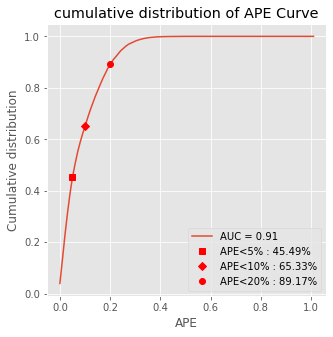

            RMSE    R2  MAPE%   AUC
Value  150867.17  0.91   8.59  0.91


In [8]:
######### The homeowner listed a value to sale as a list price ######### 
score,ES=GoF(nY['Sold Price'],nY['List Price'])

## RandomForest

### SOLD PRICE

### Hyperparameter Optimization With the Grid Search  (Random Forest)

In [10]:
param_grid = { 
    'n_estimators': range(300,1001,100),
    'max_depth' : range(5,31,5),
    'bootstrap': [True, False]
    
}
AUC = make_scorer(GS_score)
rfr=RandomForestRegressor()
rf_tune =GridSearchCV(estimator=rfr, param_grid=param_grid,
                             cv = 5,
                             scoring=AUC,
                             n_jobs = -1)
rf_opt_sold = rf_tune.fit(X_train, Y_train['Sold Price'])
print("Best AUC): " + str(rf_opt_sold.best_score_) + "\n")
print("Optimal Model:\n" + str(rf_opt_sold.best_estimator_) + "\n")
print(rf_opt_sold.best_params_)

Best AUC): 0.8888597372488407

Optimal Model:
RandomForestRegressor(max_depth=20, n_estimators=800)

{'bootstrap': True, 'max_depth': 20, 'n_estimators': 800}


### Find the optimal hyperparameters in a smaller range by Grid Search algorthim

In [19]:
param_grid = { 
    #'n_estimators': range(750,851,10),
    'n_estimators':[800],
    'max_depth' : range(15,26)  
}
AUC = make_scorer(GS_score)
rfr=RandomForestRegressor(bootstrap=True)
rf_tune =GridSearchCV(estimator=rfr, param_grid=param_grid,
                             cv = 5,
                             scoring=AUC,
                             n_jobs = -1)

rf_opt = rf_tune.fit(X_train, Y_train['Sold Price'])
print("Best AUC: " + str(rf_opt_sold.best_score_) + "\n")
print("Optimal Model:\n" + str(rf_opt_sold.best_estimator_) + "\n")
print(rf_opt_sold.best_params_)

Best AUC): 0.8888597372488407

Optimal Model:
RandomForestRegressor(max_depth=20, n_estimators=800)

{'bootstrap': True, 'max_depth': 20, 'n_estimators': 800}


### Test the model with the best parameters and plot the result

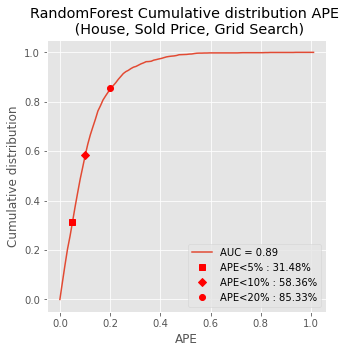

            RMSE    R2  MAPE%   AUC
Value  187659.84  0.86  11.07  0.89


In [21]:
grid_predictions = rf_opt_sold.predict(X_test)
score,ES=GoF(Y_test['Sold Price'],grid_predictions,title="RandomForest Cumulative distribution APE \n (House, Sold Price, Grid Search)")

### K-Fold Cross Validation for the random forest model,K=50

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50              mean        std
RMSE   183206.881  14509.865
R2          0.867      0.021
MAPE%      10.963      0.530
AUC         0.891      0.005


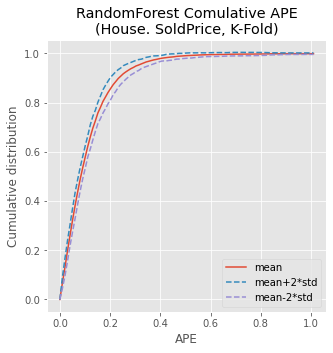

             mean       std
APE<5%   0.322717  0.023901
APE<10%  0.579484  0.022863
APE<20%  0.857595  0.022993


In [18]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    rfr=RandomForestRegressor(n_estimators=800,
                              max_depth=20,
                              bootstrap=True).fit(nX.iloc[train_index],
                                                  nY.iloc[train_index]['Sold Price'])
                                
    y_pred=rfr.predict(nX.iloc[test_index])
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    print(i,end=" ")
    
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="RandomForest Comulative APE\n(House. SoldPrice, K-Fold)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))

In [23]:
CDF_mean[[5,10,20]]

array([0.32205802, 0.57902437, 0.85884146])

In [27]:
CDF[:,[5,10,20]]
CDF[:,[5,10,20]].max(axis=0)

array([0.3704918 , 0.62828947, 0.91118421])

In [28]:
CDF[:,[5,10,20]].min(axis=0)

array([0.25986842, 0.53114754, 0.78618421])

In [29]:
AUC_list=[]
for row in CDF:
    AUC_list.append(np.trapz(row, dx=0.01))
print(max(AUC_list))
print(min(AUC_list))

0.9003947368421051
0.8791611842105262


### Log Sold Price

## Hyperparameter Optimization With the Grid Search  (Random Forest)

In [14]:
param_grid = { 
    'n_estimators': range(700,1501,100),
    'max_depth' : range(15,41,5),
    'bootstrap': [True, False]
    
}
AUC = make_scorer(Log_GS_score)
rfr=RandomForestRegressor()
rf_tune =GridSearchCV(estimator=rfr, param_grid=param_grid,
                             cv = 5,
                             scoring=AUC,
                             n_jobs = -1)
rf_opt_log = rf_tune.fit(X_train, Y_train['log price'])
print("Best AUC): " + str(rf_opt_log.best_score_) + "\n")
print("Optimal Model:\n" + str(rf_opt_log.best_estimator_) + "\n")
print(rf_opt_log.best_params_)

Best ACC(APE<20%): 0.858

Optimal Model:
RandomForestRegressor(max_depth=20, n_estimators=1100)

{'bootstrap': True, 'max_depth': 20, 'n_estimators': 1100}


### Find the optimal hyperparameters in a smaller range by Grid Search algorthim

In [11]:
param_grid = { 
    'n_estimators': range(1050,1151,10),
    'max_depth' : range(16,24),
    
}
AUC = make_scorer(Log_GS_score)
rfr=RandomForestRegressor()
rf_tune =GridSearchCV(estimator=rfr, param_grid=param_grid,
                             cv = 5,
                             scoring=AUC,
                             n_jobs = -1)

rf_opt = rf_tune.fit(X_train, Y_train['log price'])
print("Best AUC: " + str(rf_opt.best_score_) + "\n")
print("Optimal Model:\n" + str(rf_opt.best_estimator_) + "\n")
print(rf_opt.best_params_)

Best AUC: 0.9913956723338485

Optimal Model:
RandomForestRegressor(max_depth=21, n_estimators=1090)

{'max_depth': 21, 'n_estimators': 1090}


#### Test the model with the best parameters and plot the result

In [19]:
rfr_log=RandomForestRegressor(n_estimators=1090,
                              max_depth=21,
                              bootstrap=True).fit(X_train, Y_train['log price'])
                                

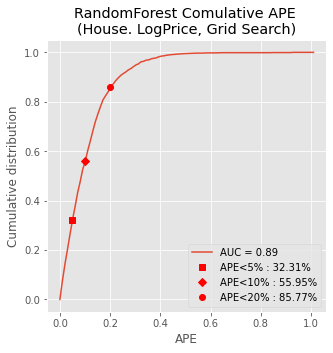

            RMSE    R2  MAPE%   AUC
Value  187881.15  0.86  10.95  0.89


In [20]:
grid_predictions_log = np.exp(rfr_log.predict(X_test))/_MAX_Y
score,ES=GoF(Y_test['Sold Price'],grid_predictions_log,title="RandomForest Comulative APE \n(House. LogPrice, Grid Search)") 

#### K-Fold Cross Validation, K=50

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50              mean        std
RMSE   184677.250  15264.869
R2          0.865      0.021
MAPE%      10.760      0.503
AUC         0.893      0.005


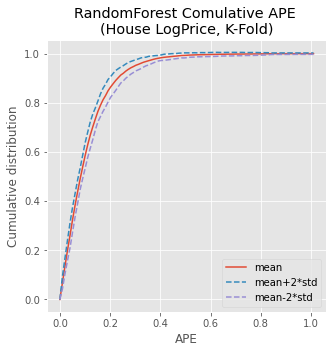

             mean       std
APE<5%   0.324426  0.025283
APE<10%  0.586908  0.026006
APE<20%  0.863833  0.021001


In [8]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    rfr=RandomForestRegressor(n_estimators=490,
                              max_depth=20,
                              bootstrap=True).fit(nX.iloc[train_index],
                                                  nY.iloc[train_index]['log price'])
                                
    y_pred=np.exp(rfr.predict(nX.iloc[test_index]))/_MAX_Y
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    print(i,end=" ")
    
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="RandomForest Comulative APE \n(House LogPrice, K-Fold)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))

## XGBoost

### Sold Price

### Hyperparameter Optimization With the Grid Search (XGBoost)

In [19]:
parameters = {'n_estimators': range(20,200,25), 'max_depth':range(5,51,5)}
XGB_base =xgb.XGBRegressor()
AUC = make_scorer(GS_score)
XGB_tuned = GridSearchCV(XGB_base, parameters,
                         cv = 5,
                         scoring=AUC,
                         n_jobs = -1)

XGB_opt =XGB_tuned.fit(X_train, Y_train['Sold Price'])
print("Best AUC:" + str(XGB_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(XGB_opt.best_estimator_) + "\n")
print(XGB_opt.best_params_)

Best ACC(APE<20%):0.868

{'max_depth': 5, 'n_estimators': 70}


### Find the optimal hyperparameters in a smaller range by Grid Search algorthim

In [20]:
parameters = {'n_estimators': range(300,1001,20), 'max_depth':range(3,10)}
XGB_base =xgb.XGBRegressor()
AUC = make_scorer(GS_score)
XGB_tuned = GridSearchCV(XGB_base, parameters,
                         cv = 5,
                         scoring=AUC,
                         n_jobs = -1)

XGB_opt =XGB_tuned.fit(X_train, Y_train['Sold Price'])
print("Best AUC):" + str(XGB_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(XGB_opt.best_estimator_) + "\n")
print(XGB_opt.best_params_)

Best ACC(APE<20%):0.8699999999999999

{'max_depth': 5, 'n_estimators': 77}


#### Test the model with the best parameters and plot the result

In [ ]:
grid_predictions = XGB_opt.predict(X_test)
score,ES=GoF(Y_test['Sold Price'],grid_predictions,title="XGBRegressor Comulative APE \n(House Sold Price, Grid Search)")

In [21]:
xgb_sold=xgb.XGBRegressor(n_estimators=77,
                              max_depth=5
                              ).fit(X_train, Y_train['Sold Price'])
                                

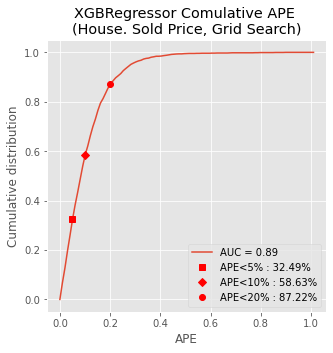

            RMSE    R2  MAPE%   AUC
Value  173401.89  0.88  10.55  0.89


In [22]:
grid_predictions_sold =xgb_sold.predict(X_test)
score,ES=GoF(Y_test['Sold Price'],grid_predictions_sold,title="XGBRegressor Comulative APE \n(House. Sold Price, Grid Search)") 

#### K-Fold Cross Validation (target=sold price), k=50

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50              mean       std
RMSE   138459.469  9719.516
R2          0.924     0.012
MAPE%       8.908     0.425
AUC         0.911     0.004


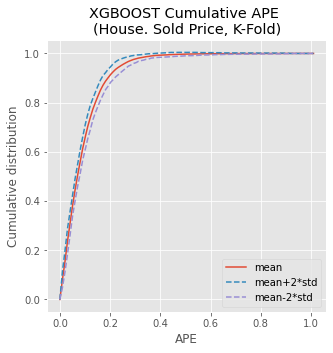

             mean       std
APE<5%   0.381434  0.021172
APE<10%  0.660338  0.025290
APE<20%  0.914410  0.015810


In [26]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    
    XGB_opt=xgb.XGBRegressor(n_estimators=77,
                         max_depth=5).fit(X_train,Y_train['Sold Price'])                                         
                            
    y_pred=XGB_opt.predict(nX.iloc[test_index])
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    print(i,end=' ')
    
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="XGBOOST Cumulative APE \n(House. Sold Price, K-Fold)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))

### Log of Sold Price

### Hyperparameter Optimization With the Grid Search (XGBoost)

In [ ]:
parameters = {'n_estimators': range(100,1001,25), 'max_depth':range(2,21,2)}
XGB_base =xgb.XGBRegressor()
AUC = make_scorer(Log_GS_score)
XGB_tuned = GridSearchCV(XGB_base, parameters,
                         cv = 5,
                         scoring=AUC,
                         n_jobs = -1)

XGB_opt =XGB_tuned.fit(X_train, Y_train['log price'])
print("Best AUC:" + str(XGB_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(XGB_opt.best_estimator_) + "\n")
print(XGB_opt.best_params_)

### Find the optimal hyperparameters in a smaller range by Grid Search algorthim

In [23]:
parameters = {'n_estimators': range(115,125), 'max_depth':range(3,21)}
XGB_base =xgb.XGBRegressor()
AUC = make_scorer(Log_GS_score)
XGB_tuned = GridSearchCV(XGB_base, parameters,
                         cv = 5,
                         scoring=AUC,
                         n_jobs = -1)

XGB_opt =XGB_tuned.fit(X_train, Y_train['log price'])
print("Best AUC:" + str(XGB_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(XGB_opt.best_estimator_) + "\n")
print(XGB_opt.best_params_)

Best ACC(APE<20%):0.8779999999999999

{'max_depth': 4, 'n_estimators': 115}


#### Test the model with the best parameters and plot the result

In [23]:
                                                                
xgb_log=xgb.XGBRegressor(n_estimators=115,
                              max_depth=4
                              ).fit(X_train, Y_train['log price'])
                                

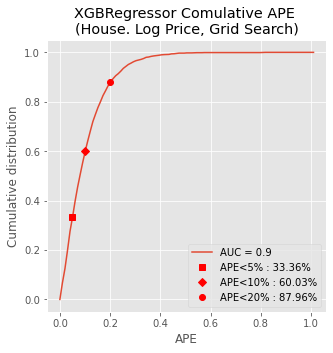

            RMSE    R2  MAPE%  AUC
Value  171477.08  0.88   10.2  0.9


In [24]:
grid_predictions_log = np.exp(xgb_log.predict(X_test))/_MAX_Y
score,ES=GoF(Y_test['Sold Price'],grid_predictions_log,title="XGBRegressor Comulative APE \n(House. Log Price, Grid Search)") 

#### K-Fold cross validation , K=50

             mean        std
RMSE   172108.526  12026.379
R2          0.883      0.016
MAPE%      10.181      0.488
AUC         0.898      0.005


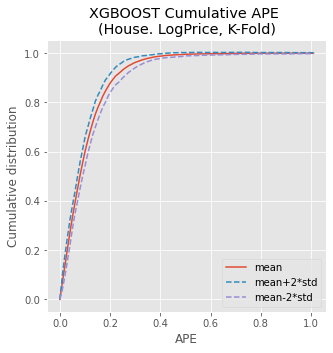

             mean       std
APE<5%   0.337430  0.023542
APE<10%  0.604372  0.029270
APE<20%  0.880910  0.019011
             mean       std
APE<5%   0.337430  0.023542
APE<10%  0.604372  0.029270
APE<20%  0.880910  0.019011


In [9]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    
    XGBoost=xgb.XGBRegressor(n_estimators=115,
                         max_depth=4).fit(nX.iloc[train_index],
                                                  nY.iloc[train_index]['log price'])
      
                                
    y_pred=np.exp(XGBoost.predict(nX.iloc[test_index]))/_MAX_Y
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="XGBOOST Cumulative APE \n(House. LogPrice, K-Fold)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))

## SVR

### Sold Price

### Hyperparameter Optimization With the Grid Search (SVR)

In [31]:
parameters = {'kernel':('linear','poly','rbf'), 'C':range(1,30)}
SVR_base = SVR(degree=2) #defult()
AUC = make_scorer(GS_score)
SVR_tuned = GridSearchCV(estimator=SVR_base, param_grid=parameters,
                         cv = 5,scoring=AUC,n_jobs = -1)

SVR_opt =SVR_tuned.fit(X_train, Y_train['Sold Price'])
print("Best AUC: " + str(SVR_opt.best_score_) + "\n")
print(SVR_opt.best_params_)

Best ACC(APE<20%: 0.7539999999999999

{'C': 1, 'kernel': 'rbf'}


#### Find the optimal hyperparameters in a smaller range by Grid Search algorthim

In [41]:
parameters = {'C':[0.1*x for x in range(5,16)]}
SVR_base = SVR(kernel='rbf') #defult()
AUC = make_scorer(GS_score)
SVR_tuned = GridSearchCV(estimator=SVR_base, param_grid=parameters,
                         cv = 5,scoring=AUC,n_jobs = -1)

SVR_opt =SVR_tuned.fit(X_train, Y_train['Sold Price'])
print("Best AUC: " + str(SVR_opt.best_score_) + "\n")
print(SVR_opt.best_params_)

Best ACC(APE<20%: 0.7539999999999999

{'C': 0.8}


#### Test the model with the best parameters and plot the result

In [13]:
SVRegressor_sold=SVR(kernel='rbf', C=0.8,epsilon=0.1).fit(X_train, Y_train['Sold Price'])

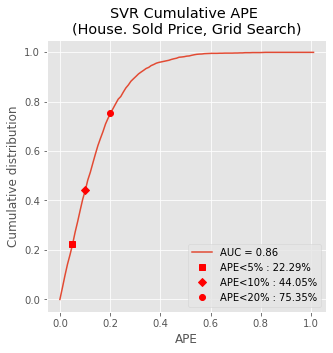

            RMSE    R2  MAPE%   AUC
Value  192535.56  0.85  14.39  0.86


In [14]:

y_pred=SVRegressor_sold.predict(X_test)
score,ES=GoF(Y_test['Sold Price'],y_pred,title="SVR Cumulative APE \n(House. Sold Price, Grid Search)")

#### SVR(sp) K-Fold Cross Validation

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50              mean        std
RMSE   189464.635  11230.062
R2          0.858      0.018
MAPE%      13.941      0.723
AUC         0.861      0.007


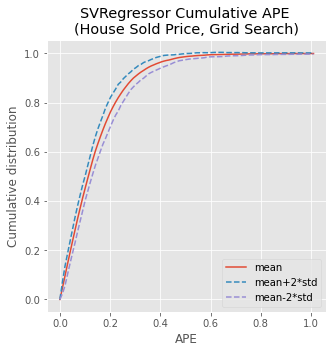

             mean       std
APE<5%   0.237598  0.024028
APE<10%  0.453501  0.025080
APE<20%  0.763469  0.029421


In [15]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    
    SVRegressor=SVR(kernel='rbf', C=0.8,epsilon=0.1).fit(nX.iloc[train_index],
                                                  nY.iloc[train_index]['Sold Price'])                                    
                            
    y_pred=SVRegressor.predict(nX.iloc[test_index])
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    print(i,end=" ")
    
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="SVRegressor Cumulative APE \n(House Sold Price, Grid Search)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))

### Log Price

In [33]:
parameters = {'kernel':('linear','poly','rbf'), 'C':range(1,30)}
SVR_base = SVR(degree=2) #defult()
AUC = make_scorer(Log_GS_score)
SVR_tuned = GridSearchCV(estimator=SVR_base, param_grid=parameters,
                         cv = 5,scoring=AUC,n_jobs = -1)
                                
SVR_opt =SVR_tuned.fit(X_train, Y_train['log price'])
print("Best AUC: " + str(SVR_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(SVR_opt.best_estimator_) + "\n")
print(SVR_opt.best_params_)

Best ACC(APE<20%: 0.8640000000000001

{'C': 2, 'kernel': 'rbf'}


In [43]:
parameters = {'C':[0.1*x for x in range(15,26)]}
SVR_base = SVR(kernel='rbf') #defult()
AUC = make_scorer(Log_GS_score)
SVR_tuned = GridSearchCV(estimator=SVR_base, param_grid=parameters,
                         cv = 5,scoring=AUC,n_jobs = -1)
                                
SVR_opt =SVR_tuned.fit(X_train, Y_train['log price'])
print("Best AUC: " + str(SVR_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(SVR_opt.best_estimator_) + "\n")
print(SVR_opt.best_params_)

Best zero-one score: 0.8640000000000001

{'C': 1.7000000000000002}


#### Test the model with the best parameters and plot the result

In [10]:
SVRegressor_log=SVR(kernel='rbf', C=1.7,epsilon=0.1).fit(X_train, Y_train['log price'])

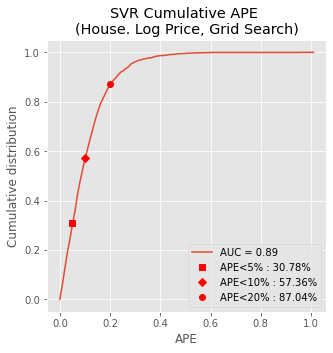

            RMSE    R2  MAPE%   AUC
Value  173778.45  0.88  10.68  0.89


In [12]:
y_pred=np.exp(SVRegressor_log.predict(X_test))/_MAX_Y
score,ES=GoF(Y_test['Sold Price'],y_pred,title="SVR Cumulative APE \n(House. Log Price, Grid Search)")

### SVR(log of sold price) K-Fold Cross Validation

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50              mean        std
RMSE   176421.930  13040.102
R2          0.877      0.017
MAPE%      10.628      0.518
AUC         0.894      0.005


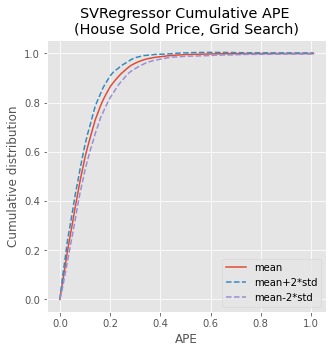

             mean       std
APE<5%   0.312473  0.023456
APE<10%  0.582047  0.025801
APE<20%  0.867312  0.021925


In [17]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    
    SVRegressor=SVR(kernel='rbf', C=0.8,epsilon=0.1).fit(nX.iloc[train_index],
                                                  nY.iloc[train_index]['log price'])                                    
                            
    y_pred=np.exp(SVRegressor.predict(nX.iloc[test_index]))/_MAX_Y
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    print(i,end=" ")
    
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="SVRegressor Cumulative APE \n(House Log Price, Grid Search)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))